In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

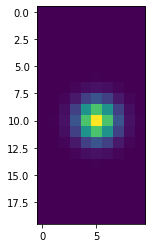

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=3):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [5]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # left
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # right
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    face_idx = np.array([[1,2,6,5], # front face
                         [2,3,7,6], # left face
                         [3,4,8,7], # back face
                         [4,1,5,8]]) # right face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz # 直方体の各頂点のxyz座標
    
    visible_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner2D = projectToImage(corner3D, P) # 画像座標に変換

    return visible_flag, corner2D, face_idx

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

def getCorner3D(img_name):
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    _, _, P2, _, _, _, _ = readCalib(img_name, self.calib_path)

    visible_flags, corner3Ds = [], []
    for _, anno in annotations.iterrows():
        visible_flag, corner3D, face_idx = compute3Dbb(anno, P2)
        visible_flags.append(visible_flag)
        corner3Ds.append(corner3D)
    return visible_flags, corner3Ds

In [6]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    off_x = randint(0, IMG_WIDTH-img_shape[1])
    off_y = randint(0, IMG_HEIGHT-img_shape[0])
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    mask_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    #height, width
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    #x_(flt,flb,frt,frb,blt,blb,brt,brb),y_(flt,flb,frt,frb,blt,blb,brt,brb)
    regr_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 16], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = x+offset[0]/ MODEL_SCALE
            y = y+offset[1]/ MODEL_SCALE
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(x-w/2).astype('int')
            top = np.round(y-h/2).astype('int')
            right = np.round(x+w/2).astype('int')
            bottom = np.round(y+h/2).astype('int')
            hm = get_heatmap(right-left, bottom-top, w/2, h/2)

            ## cornerの座標を計算
            vsbl_flg, cnr, _ = compute3Dbb(anno, P2)
            cnr[0] = (cnr[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)
            cv2.fillConvexPoly(mask_cnr, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right] = hm
            regr[top:bottom, left:right, 0] = height
            regr[top:bottom, left:right, 1] = width
            
            # cornerの位置の学習データ
            # 初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,8).reshape(8,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,8)
            regr_cnr[top:bottom, left:right,:8] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,8).reshape(8,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,8)
            regr_cnr[top:bottom, left:right,8:] = nums
            # coner位置までのx,y方向pixel数
            for i in range(8):
                regr_cnr[top:bottom, left:right,i] -= (cnr[0,i]-left) # xベクトル
                regr_cnr[top:bottom, left:right,i+8] -= (cnr[1,i]-top) # yベクトル

            # cornerの学習データを作成
            cnr = cnr[:,vsbl_flg]
            cnr = np.round(cnr).astype('int')
            if w > 5:
                for i in range(8):
                    try:
                        # コーナーが見えないor画像外だったら何もしない
                        mask_cnr[cnr[1,i],cnr[0,i]] = 1
                    except:
                        pass
    
    return mask, regr, mask_cnr, regr_cnr

original image


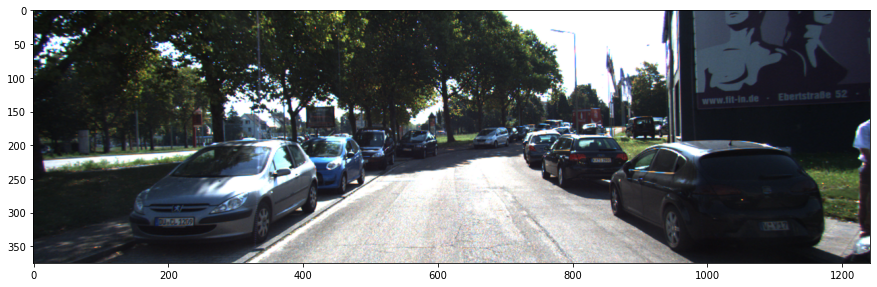

In [7]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

img_name = train_list[2]
img_name_list = get_img_path([img_name])

print("original image")
img = plt.imread(img_name_list[0])
plt.figure(figsize=(15,8))
plt.imshow(img)

resized image


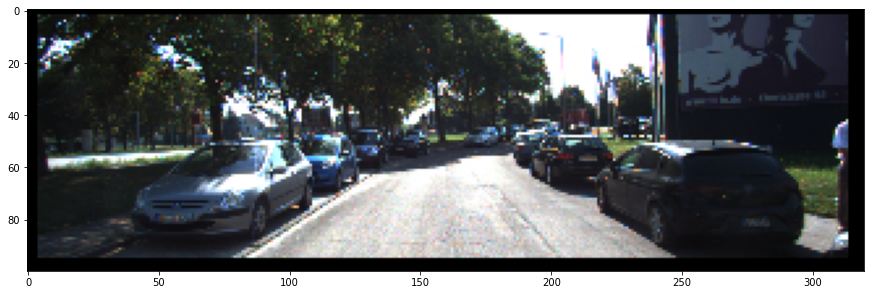

In [8]:
print("resized image")
img, offset = preprocess_image(img)
plt.figure(figsize=(15,8))
plt.imshow(img*255)

vehicle mask
regr
corner mask
corner regr x
corner regr y


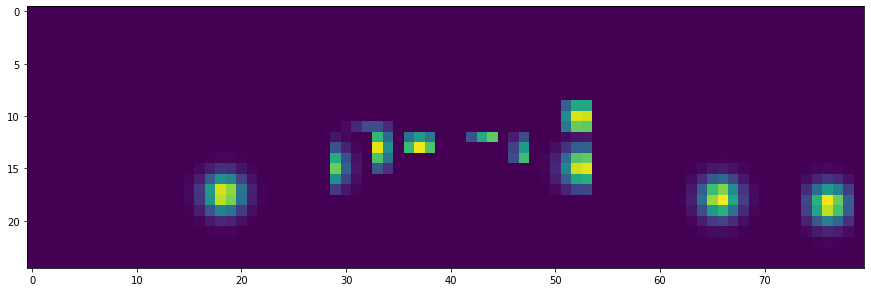

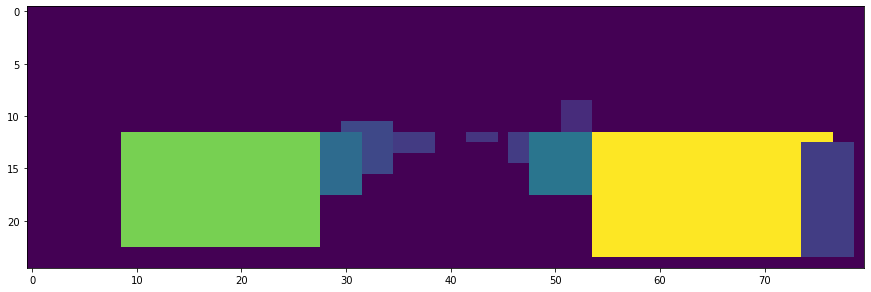

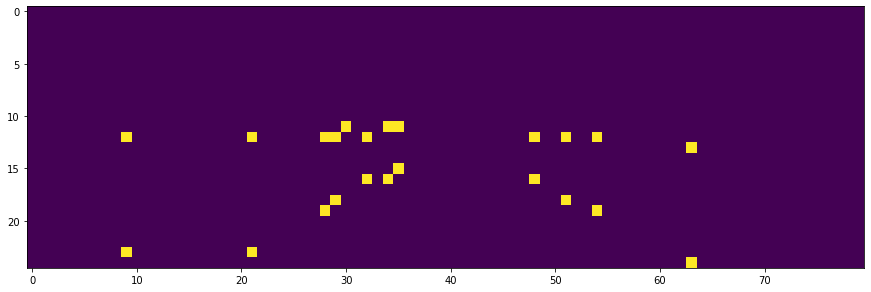

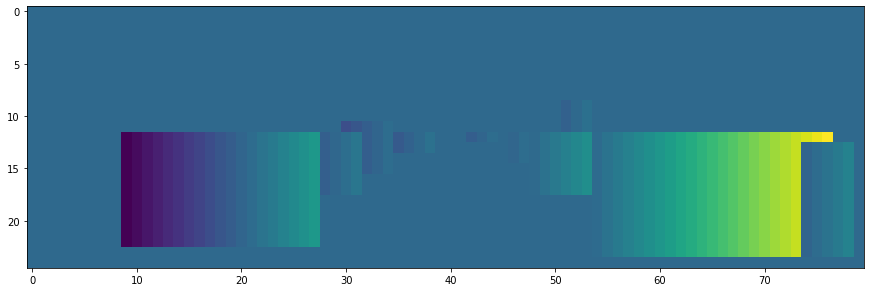

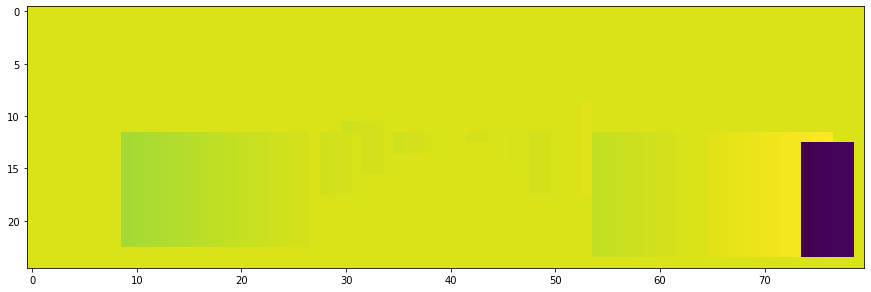

In [9]:
mask, regr, mask_cnr, regr_cnr = get_mask_and_regr(img_name, annotations_list, offset)
print("vehicle mask")
plt.figure(figsize=(15,8))
plt.imshow(mask)
print("regr")
plt.figure(figsize=(15,8))
plt.imshow(regr[:,:,1])
print("corner mask")
plt.figure(figsize=(15,8))
plt.imshow(mask_cnr)
print("corner regr x")
plt.figure(figsize=(15,8))
plt.imshow(regr_cnr[:,:,0])
print("corner regr y")
plt.figure(figsize=(15,8))
plt.imshow(regr_cnr[:,:,3])

# 学習データ生成のためのclassを定義

In [10]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img)
        mask, regr, mask_cnr, regr_cnr = get_mask_and_regr(img_name, self.anno, offset)
        
        # Augmentation
        if self.training:
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr, mask_cnr, regr_cnr = img[:,::-1], mask[:,::-1], regr[:,::-1], mask_cnr[:,::-1], regr_cnr[:,::-1]
                regr_cnr[:,:,:8] *= -1
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr, mask_cnr, regr_cnr = img[::-1], mask[::-1], regr[::-1], mask_cnr[::-1], regr_cnr[::-1]
                regr_cnr[:,:,8:] *= -1
                
        # 配列の向き？を入れ替える
        img = np.rollaxis(img, 2, 0)
        regr = np.rollaxis(regr, 2, 0)
        regr_cnr = np.rollaxis(regr_cnr, 2, 0)
            
        return [img.copy(), mask.copy(), regr.copy(), mask_cnr.copy(), regr_cnr.copy()]

In [11]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [12]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# DL Model

In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [15]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [16]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [17]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 50

## MyUNetの出力ベクトル長を設定
model = MyUNet(20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=1,
                              verbose=True
                             )
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 4, gamma=0.1)

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [18]:
lambda_size = 0.1
lambda_offset = 0.1

def criterion(prediction, mask, regr, mask_cnr, regr_cnr):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    # mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:3]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    regr_loss = regr_loss.mean(0)
    
    # mask_corner _loss
    pred_mask_cnr = torch.sigmoid(prediction[:, 3])
    mask_cnr_loss = mask_cnr * torch.log(pred_mask_cnr + 1e-12) + (1 - mask_cnr) * torch.log(1 - pred_mask_cnr + 1e-12)
    mask_cnr_loss = -mask_cnr_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 4:]
    regr_cnr_loss = (torch.abs(pred_regr - regr_cnr).sum(1) * mask).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    regr_cnr_loss = regr_cnr_loss.mean(0)
    
    return mask_loss, lambda_size*regr_loss, mask_cnr_loss, lambda_offset*regr_cnr_loss

In [19]:
FINE_TUNE_EPOCH = 18

def train_model(epoch, history=None):
    model.train()
    train_mask_loss = 0
    train_regr_loss = 0
    train_mask_cnr_loss = 0
    train_regr_cnr_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_batch, cnr_batch, regr_cnr_batch) in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        cnr_batch = cnr_batch.to(device)
        regr_cnr_batch = regr_cnr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        mask_loss, regr_loss, mask_cnr_loss, regr_cnr_loss =\
            criterion(output, mask_batch, regr_batch, cnr_batch, regr_cnr_batch)
        loss = mask_loss + regr_loss + mask_cnr_loss + regr_cnr_loss
        loss.backward()
        optimizer.step()
        
        train_mask_loss += mask_loss.detach()
        train_regr_loss += regr_loss.detach()
        train_mask_cnr_loss += mask_cnr_loss.detach()
        train_regr_cnr_loss += regr_cnr_loss.detach()
    
    train_mask_loss /= len(train_dataset)
    train_regr_loss /= len(train_dataset)
    train_mask_cnr_loss /= len(train_dataset)
    train_regr_cnr_loss /= len(train_dataset)
    train_loss = train_mask_loss + train_regr_loss + train_mask_cnr_loss + train_regr_cnr_loss
    
    if history is not None:
        history.loc[epoch, 'train_mask_loss'] = train_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_loss'] = train_regr_loss.data.cpu().numpy()
        history.loc[epoch, 'train_mask_cnr_loss'] = train_mask_cnr_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_cnr_loss'] = train_regr_cnr_loss.data.cpu().numpy()
        history.loc[epoch, 'train_loss'] = train_loss.data.cpu().numpy()
        
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        train_loss.data.cpu().numpy()))

def evaluate_model(epoch, history=None):
    model.eval()
    val_mask_loss = 0
    val_regr_loss = 0
    val_mask_cnr_loss = 0
    val_regr_cnr_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch, cnr_batch, regr_cnr_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)
            cnr_batch = cnr_batch.to(device)
            regr_cnr_batch = regr_cnr_batch.to(device)

            output = model(img_batch)

            mask_loss, regr_loss, mask_cnr_loss, regr_cnr_loss =\
                criterion(output, mask_batch, regr_batch, cnr_batch, regr_cnr_batch)
            val_mask_loss += mask_loss.detach()
            val_regr_loss += regr_loss.detach()
            val_mask_cnr_loss += mask_cnr_loss.detach()
            val_regr_cnr_loss += regr_cnr_loss.detach()
    
    val_mask_loss /= len(val_dataset)
    val_regr_loss /= len(val_dataset)
    val_mask_cnr_loss /= len(val_dataset)
    val_regr_cnr_loss /= len(val_dataset)
    val_loss = val_mask_loss + val_regr_loss + val_mask_cnr_loss + val_regr_cnr_loss
    
    if history is not None:
        history.loc[epoch, 'val_mask_loss'] = val_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_loss'] = val_regr_loss.data.cpu().numpy()
        history.loc[epoch, 'val_mask_cnr_loss'] = val_mask_cnr_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_cnr_loss'] = val_regr_cnr_loss.data.cpu().numpy()
        history.loc[epoch, 'val_loss'] = val_loss.data.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))
    
    scheduler.step(val_loss)

In [20]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    if epoch == 0:
        print("Base model parameters are FREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = False
    elif epoch == FINE_TUNE_EPOCH:
        print("Base model parameters are UNFREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = True
            
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')

Base model parameters are FREEZED.


100%|██████████| 445/445 [08:16<00:00,  1.12s/it]

Train Epoch: 0 	LR: 0.100000	Loss: 27.626411


Val loss: 39.8152


100%|██████████| 445/445 [08:11<00:00,  1.11s/it]

Train Epoch: 1 	LR: 0.100000	Loss: 25.512016


Val loss: 19.6574


100%|██████████| 445/445 [08:30<00:00,  1.15s/it]

Train Epoch: 2 	LR: 0.100000	Loss: 25.048456


Val loss: 18.7932


100%|██████████| 445/445 [08:14<00:00,  1.11s/it]

Train Epoch: 3 	LR: 0.100000	Loss: 24.603283


Val loss: 18.3732


100%|██████████| 445/445 [08:36<00:00,  1.16s/it]

Train Epoch: 4 	LR: 0.100000	Loss: 24.212252


Val loss: 17.8487


100%|██████████| 445/445 [08:23<00:00,  1.13s/it]

Train Epoch: 5 	LR: 0.100000	Loss: 23.930164


Val loss: 17.7311


100%|██████████| 445/445 [08:41<00:00,  1.17s/it]

Train Epoch: 6 	LR: 0.100000	Loss: 23.504383


Val loss: 17.2552


100%|██████████| 445/445 [09:12<00:00,  1.24s/it]

Train Epoch: 7 	LR: 0.100000	Loss: 23.138083


Val loss: 17.0585


100%|██████████| 445/445 [09:55<00:00,  1.34s/it]

Train Epoch: 8 	LR: 0.100000	Loss: 22.849010


Val loss: 16.7252


100%|██████████| 445/445 [09:35<00:00,  1.29s/it]

Train Epoch: 9 	LR: 0.100000	Loss: 22.604805


Val loss: 16.6028


100%|██████████| 445/445 [10:06<00:00,  1.36s/it]

Train Epoch: 10 	LR: 0.100000	Loss: 22.460970


Val loss: 16.6091


100%|██████████| 445/445 [09:43<00:00,  1.31s/it]

Train Epoch: 11 	LR: 0.100000	Loss: 22.220409


Val loss: 16.2756


100%|██████████| 445/445 [11:15<00:00,  1.52s/it]

Train Epoch: 12 	LR: 0.100000	Loss: 22.031605


Val loss: 16.6987


100%|██████████| 445/445 [10:37<00:00,  1.43s/it]

Train Epoch: 13 	LR: 0.100000	Loss: 21.982162


Val loss: 16.3512
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.


100%|██████████| 445/445 [09:59<00:00,  1.35s/it]

Train Epoch: 14 	LR: 0.010000	Loss: 21.128355


Val loss: 15.2737


100%|██████████| 445/445 [09:45<00:00,  1.32s/it]

Train Epoch: 15 	LR: 0.010000	Loss: 20.915792


Val loss: 15.2407


100%|██████████| 445/445 [09:11<00:00,  1.24s/it]

Train Epoch: 16 	LR: 0.010000	Loss: 20.880672


Val loss: 15.1253


100%|██████████| 445/445 [09:12<00:00,  1.24s/it]

Train Epoch: 17 	LR: 0.010000	Loss: 20.742733


Val loss: 15.1666
Base model parameters are UNFREEZED.


100%|██████████| 445/445 [16:47<00:00,  2.26s/it]

Train Epoch: 18 	LR: 0.010000	Loss: 23.402845


Val loss: 22.1762
Epoch    19: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 445/445 [17:10<00:00,  2.32s/it]

Train Epoch: 19 	LR: 0.001000	Loss: 21.913185


Val loss: 15.5109


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 20 	LR: 0.001000	Loss: 21.443718


Val loss: 15.2793
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 445/445 [16:27<00:00,  2.22s/it]

Train Epoch: 21 	LR: 0.000100	Loss: 21.294140


Val loss: 15.0407


100%|██████████| 445/445 [16:33<00:00,  2.23s/it]

Train Epoch: 22 	LR: 0.000100	Loss: 21.199089


Val loss: 15.0256


100%|██████████| 445/445 [16:34<00:00,  2.24s/it]

Train Epoch: 23 	LR: 0.000100	Loss: 21.164577


Val loss: 14.9837


100%|██████████| 445/445 [16:36<00:00,  2.24s/it]

Train Epoch: 24 	LR: 0.000100	Loss: 21.119022


Val loss: 14.9917


100%|██████████| 445/445 [16:34<00:00,  2.23s/it]

Train Epoch: 25 	LR: 0.000100	Loss: 21.047228


Val loss: 14.9624


100%|██████████| 445/445 [16:37<00:00,  2.24s/it]

Train Epoch: 26 	LR: 0.000100	Loss: 21.006222


Val loss: 14.9818


100%|██████████| 445/445 [16:29<00:00,  2.22s/it]

Train Epoch: 27 	LR: 0.000100	Loss: 20.991858


Val loss: 14.9769
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 28 	LR: 0.000010	Loss: 21.078049


Val loss: 14.9826


100%|██████████| 445/445 [16:39<00:00,  2.25s/it]

Train Epoch: 29 	LR: 0.000010	Loss: 20.948589


Val loss: 14.9568


100%|██████████| 445/445 [16:33<00:00,  2.23s/it]

Train Epoch: 30 	LR: 0.000010	Loss: 20.942686


Val loss: 14.9811


100%|██████████| 445/445 [16:31<00:00,  2.23s/it]

Train Epoch: 31 	LR: 0.000010	Loss: 20.993603


Val loss: 14.9600
Epoch    32: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 445/445 [16:34<00:00,  2.23s/it]

Train Epoch: 32 	LR: 0.000001	Loss: 20.939640


Val loss: 14.9581


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 33 	LR: 0.000001	Loss: 20.947689


Val loss: 14.9609
Epoch    34: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 34 	LR: 0.000000	Loss: 20.911764


Val loss: 14.9628


100%|██████████| 445/445 [16:38<00:00,  2.24s/it]

Train Epoch: 35 	LR: 0.000000	Loss: 20.906796


Val loss: 14.9529


100%|██████████| 445/445 [16:32<00:00,  2.23s/it]

Train Epoch: 36 	LR: 0.000000	Loss: 20.983997


Val loss: 14.9590


100%|██████████| 445/445 [16:37<00:00,  2.24s/it]

Train Epoch: 37 	LR: 0.000000	Loss: 20.993650


Val loss: 14.9578
Epoch    38: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 445/445 [16:33<00:00,  2.23s/it]

Train Epoch: 38 	LR: 0.000000	Loss: 20.958063


Val loss: 14.9640


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 39 	LR: 0.000000	Loss: 20.964668


Val loss: 14.9690


100%|██████████| 445/445 [16:31<00:00,  2.23s/it]

Train Epoch: 40 	LR: 0.000000	Loss: 20.969620


Val loss: 14.9696


100%|██████████| 445/445 [16:31<00:00,  2.23s/it]

Train Epoch: 41 	LR: 0.000000	Loss: 20.975849


Val loss: 14.9562


100%|██████████| 445/445 [16:32<00:00,  2.23s/it]

Train Epoch: 42 	LR: 0.000000	Loss: 20.965786


Val loss: 14.9569


100%|██████████| 445/445 [16:32<00:00,  2.23s/it]

Train Epoch: 43 	LR: 0.000000	Loss: 20.945765


Val loss: 14.9543


100%|██████████| 445/445 [16:32<00:00,  2.23s/it]

Train Epoch: 44 	LR: 0.000000	Loss: 21.256800


Val loss: 14.9694


100%|██████████| 445/445 [16:36<00:00,  2.24s/it]

Train Epoch: 45 	LR: 0.000000	Loss: 20.896116


Val loss: 14.9471


100%|██████████| 445/445 [16:35<00:00,  2.24s/it]

Train Epoch: 46 	LR: 0.000000	Loss: 20.923996


Val loss: 14.9490


100%|██████████| 445/445 [16:34<00:00,  2.24s/it]

Train Epoch: 47 	LR: 0.000000	Loss: 20.911592


Val loss: 14.9646


100%|██████████| 445/445 [16:42<00:00,  2.25s/it]

Train Epoch: 48 	LR: 0.000000	Loss: 21.004868


Val loss: 14.9553


100%|██████████| 445/445 [16:40<00:00,  2.25s/it]

Train Epoch: 49 	LR: 0.000000	Loss: 20.986263


Val loss: 14.9620


In [21]:
torch.save(model.state_dict(), '../models/model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), '../models/model_cpu.pth')

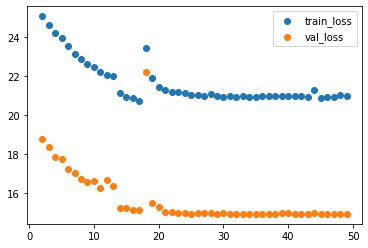

In [22]:
train_loss = history.dropna()['train_loss']
val_loss = history.dropna()['val_loss']
plt.scatter(train_loss.index[2:], train_loss[2:])
plt.scatter(val_loss.index[2:], val_loss[2:])
plt.legend(["train_loss", "val_loss"])

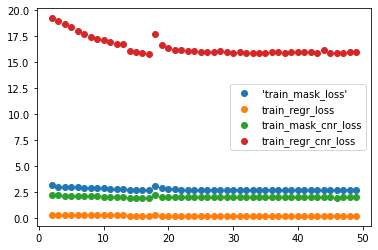

In [23]:
train_mask_loss = history.dropna()['train_mask_loss']
train_regr_loss = history.dropna()['train_regr_loss']
train_mask_cnr_loss = history.dropna()['train_mask_cnr_loss']
train_regr_cnr_loss = history.dropna()['train_regr_cnr_loss']
plt.scatter(train_loss.index[2:], train_mask_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_loss[2:])
plt.scatter(train_loss.index[2:], train_mask_cnr_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_cnr_loss[2:])
plt.legend(["'train_mask_loss'", "train_regr_loss", "train_mask_cnr_loss", "train_regr_cnr_loss"])

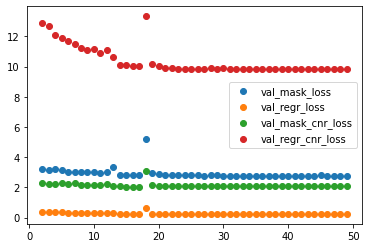

In [24]:
val_mask_loss = history.dropna()['val_mask_loss']
val_regr_loss = history.dropna()['val_regr_loss']
val_mask_cnr_loss = history.dropna()['val_mask_cnr_loss']
val_regr_cnr_loss = history.dropna()['val_regr_cnr_loss']
plt.scatter(val_loss.index[2:], val_mask_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_loss[2:])
plt.scatter(val_loss.index[2:], val_mask_cnr_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_cnr_loss[2:])
plt.legend(["val_mask_loss", "val_regr_loss", "val_mask_cnr_loss", "val_regr_cnr_loss"])

In [25]:
torch.cuda.empty_cache()
gc.collect()

0

# Check result

In [26]:
m = MyUNet(20)
m.eval()
m_state_dict = torch.load("../models/model.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

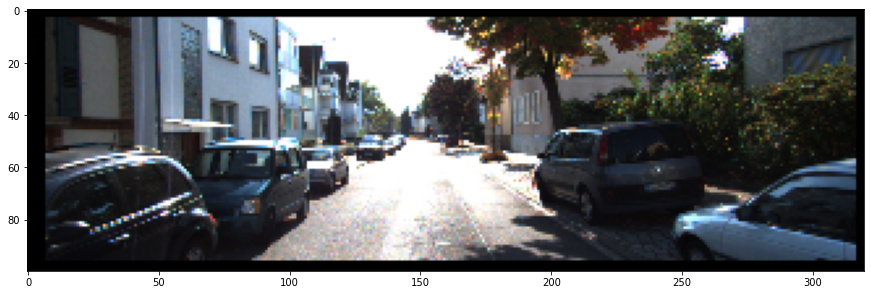

In [27]:
img, mask, regr, cnr, regr_cnr = val_dataset[0]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2*255)

In [28]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

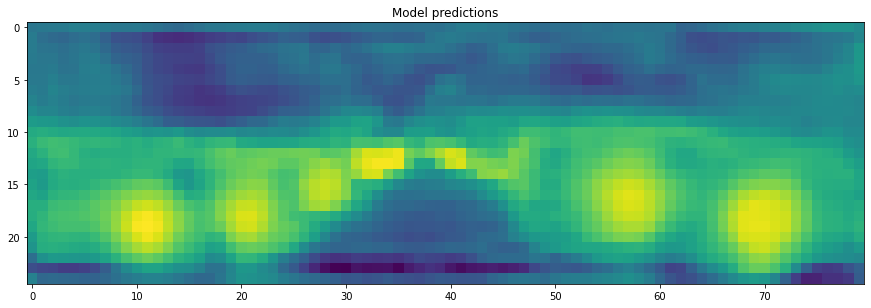

In [29]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

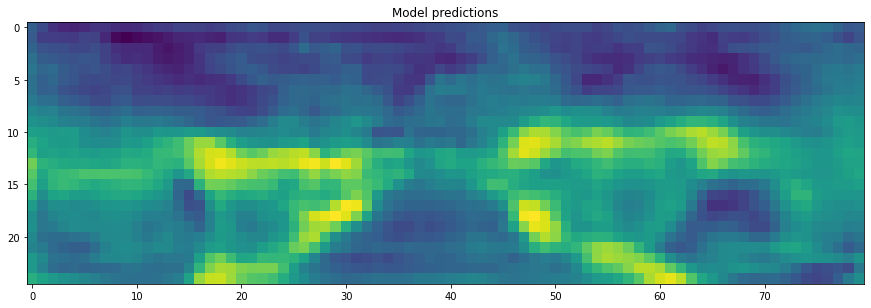

In [30]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

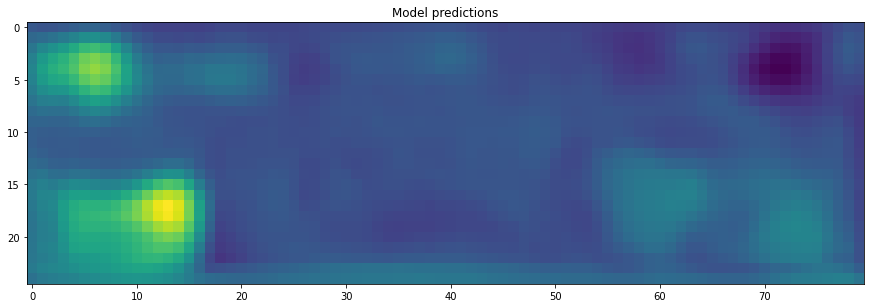

In [31]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,4].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()